# Nursery Scenario

In [1]:
from NN import *
from LTL import *
from Utility_funcs import *

from csrl.mdp import GridMDP
from csrl.oa import OmegaAutomaton
from csrl import ControlSynthesis
import numpy as np
from matplotlib import pyplot as plt
import time

2023-05-24 14:58:43.068494: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Number of Omega-automaton states (including the trap state): 43


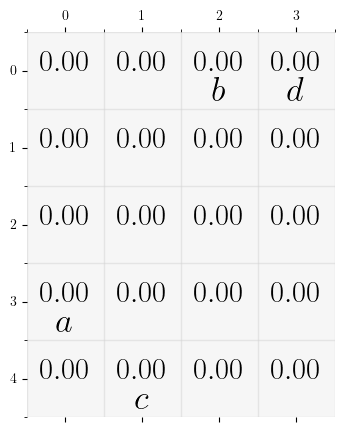

In [3]:
ltl = ('G ('
    '(!d) & '
    '(c->((!a) U b)) & '
    '((b & (X b))->(F a)) & '
    '((b & (!(X b)))->(X ((!b) U (a|c)))) & '
    '(((!b) & (X b) & (!(X X b)))->((!a) U c)) &'
    '(a->(X ((!a) U b))) '
')')

# Translate the LTL formula to an LDBA
oa = OmegaAutomaton(ltl)
print('Number of Omega-automaton states (including the trap state):',oa.shape[1])

# MDP Description
shape = (5,4)
# E: Empty, T: Trap, B: Obstacle
structure = np.array([
['E',  'E',  'E',  'E'],
['E',  'E',  'E',  'E'],
['E',  'E',  'E',  'E'],
['E',  'E',  'E',  'E'],
['E',  'E',  'E',  'E']
])

# Labels of the states
label = np.array([
[(),    (),    ('b',),('d',)],
[(),    (),    (),    ()],
[(),    (),    (),    ()],
[('a',),(),    (),    ()],
[(),    ('c',),(),    ()]
],dtype=object)
# Colors of the labels
lcmap={
    ('a',):'yellow',
    ('b',):'greenyellow',
    ('c',):'turquoise',
    ('d',):'pink'
} 
p = 1
grid_mdp = GridMDP(shape=shape,structure=structure,label=label,lcmap=lcmap, p=p, figsize=5)  # Use figsize=4 for smaller figures
grid_mdp.plot()

# Construct the product MDP
csrl = ControlSynthesis(grid_mdp,oa)
max_rew = round(csrl.reward.max(), 3)

s_vectors = state_vectors(csrl)
enc = list(np.unique(grid_mdp.label))
enc.pop(enc.index(()))
ch_states = channeled_states(csrl, enc)

In [4]:
csrl.shape, ch_states[(0,0,0,0)].shape, max_rew

((1, 43, 5, 4, 47), (5, 4, 43), 0.01)

In [5]:
model = build_model(ch_states[(0,0,0,0)].shape, csrl.shape[-1])
model.summary()

2023-05-24 14:59:28.170284: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 14:59:28.170638: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 4, 43)]   0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 5, 4, 32)     5536        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 5, 4, 8)      1032        ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 160)          0           ['conv2d_1[0][0]']               
                                                                                              

In [6]:
t = "[] ( (~d) /\ (c->(~a % b)) /\ ((b /\ >b) -> <>a) /\ ((b /\ ~>b) -> >(~b % (a \/ c))) /\ ((~b /\ >b /\ ~>>b)->(~a % c)) )"

full_t = "[] ( (~d) /\ ((b /\ ~>b) -> >(~b % (a \/ c))) /\ (a -> >(~a % b))"
full_t += " /\ ((~b /\ >b /\ ~>>b)->(~a % c)) /\ (c->(~a % b)) /\ ((b /\ >b) -> <>a) )"

LTL_formula = parser.parse(full_t)
predicates=get_predicates(grid_mdp)

In [7]:
# model = build_model(ch_states[(0,0,0,0)].shape, csrl.shape[-1])

N, W, Q, P = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape)

In [8]:
# model.load_weights(f'models/p=1/Nurseryp1')

In [10]:
global LTL_coef
LTL_coef = 1
visited_states_train = []
visited_states_test = []

search_depth = 100
MCTS_samples = 100

num_training_epochs =  5
num_test_epochs = 5
training = True
epochs = 20
# T = [20, 40, 60, 100, 200]
T = [10]
K = 1

success_rates = []
succes_std = []
win_hist = []
train_history = []

for i in T:
    # TRAIN ##############################
    train_wins = 0
    # num_training_epochs = int(200 - 1.9*i)
    # model = build_model(ch_states[(0,0,0,0)].shape, csrl.shape[-1])
    N, W, Q, P, visited = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), set()
    for epoch in range(num_training_epochs):
        t1 = time.time()
        state_history, channeled_states, trajectory, action_history, reward_history, better_policy = MC_learning(csrl, model, LTL_formula, predicates,
                csrl.reward, ch_states, N = N, W = W, Q = Q, P = P, C=3, tow=0.7, n_samples=MCTS_samples, visited=visited, start=(4,1), search_depth=search_depth,
                verbose=0, T=i, K=K)
        # print('N',N[(0,0,4,1)][:5])
        visited_states_train += state_history
        t2 = time.time()
        # print(t2-t1, " run episode")

        win = check_LTL(LTL_formula, trajectory, predicates)[0]
        if win: train_wins+=1

        t3= time.time()
        if training and len(action_history)>0:
            if epoch==0:
                x_train = np.array(channeled_states)[:-1]
                y1_train = np.array(better_policy)
                y2_train = np.array(reward_history) + LTL_coef*(check_LTL(LTL_formula, trajectory, predicates)[0]*max_rew)
                # y2_train = np.array(reward_history)
                y2_train = y2_train[:-1]
            else:
                x_train = np.concatenate((x_train, np.array(channeled_states)[:-1]),0)
                y1_train = np.concatenate((y1_train, np.array(better_policy)),0)
                y2_train_curr = np.array(reward_history) + LTL_coef*(check_LTL(LTL_formula, trajectory, predicates)[0]*max_rew)
                # y2_train_curr = np.array(reward_history)
                y2_train = np.concatenate((y2_train, y2_train_curr[:-1]),0)
            tr_hist = model.fit(x_train, [y1_train, y2_train], epochs=epochs, verbose=0)
            train_history += tr_hist.history['loss']
        win_hist.append(win)
        t4 = time.time()
        # print(t4-t3, " fit")
    print("Train wins:",train_wins,"/", num_training_epochs)

    # TEST ##############################
    test_wins = 0
    N, W, Q, P, visited = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), set()
    for epoch in range(num_test_epochs):
        
        state_history, channeled_states, trajectory, action_history, reward_history, better_policy = MC_learning(csrl, model, LTL_formula, predicates,
                csrl.reward, ch_states, N = N, W = W, Q = Q, P = P, C=3, tow=0.7, n_samples=100, visited=visited, start=(4,1), search_depth=search_depth, verbose=0, T=i, K=1)

        win = check_LTL(LTL_formula, trajectory, predicates)[0]
        if win: test_wins+=1
        win_hist.append(win)
        visited_states_test += state_history
        
    success_rates.append(100*test_wins/num_test_epochs)
    temp = np.zeros(num_test_epochs)
    temp[:test_wins]=1
    std = np.sqrt(num_test_epochs*np.var(temp))
    succes_std.append((success_rates[-1]-std, success_rates[-1]+std))
    ###############################################################
    print("Test wins:",test_wins,"/",num_test_epochs)
    # print("last reward:", reward_history[-1], "  | trajectory:", trajectory)
    # print("Actions:", action_history)

LTL [---]  LDBA [ 0.0 ] path: [17, 16, 16, 17, 13, 14, 10, 6, 7, 6]
LTL [---]  LDBA [ 0.0 ] path: [17, 17, 18, 19, 15, 19, 15, 11, 7, 6]
LTL [+++]  LDBA [ 0.0 ] path: [17, 17, 18, 19, 15, 11, 7, 6, 2, 2]
LTL [+++]  LDBA [ 0.0 ] path: [17, 17, 18, 19, 15, 14, 10, 6, 2, 2]
LTL [+++]  LDBA [ 0.0 ] path: [17, 17, 18, 19, 15, 11, 10, 6, 2, 2]
Train wins: 3 / 5
LTL [+++]  LDBA [ 0.0 ] path: [17, 16, 17, 18, 19, 15, 11, 10, 6, 2]
LTL [+++]  LDBA [ 0.0 ] path: [17, 17, 18, 19, 15, 11, 10, 6, 2, 2]
LTL [+++]  LDBA [ 0.0 ] path: [17, 16, 17, 18, 19, 15, 14, 10, 6, 2]
LTL [+++]  LDBA [ 0.0 ] path: [17, 17, 18, 19, 15, 11, 7, 6, 2, 2]
LTL [+++]  LDBA [ 0.0 ] path: [17, 17, 18, 19, 15, 11, 7, 6, 2, 2]
Test wins: 5 / 5


[100.0]

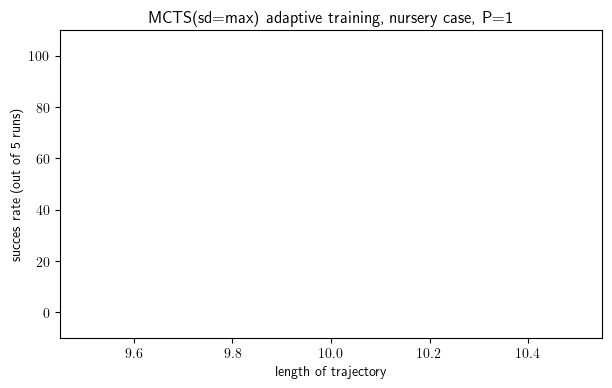

In [11]:
succes_std = np.array(succes_std)

plt.figure(figsize=(7,4))
plt.fill_between(T, succes_std[:,0], succes_std[:,1], alpha=0.3, label="MCTS area of 1 STD")

plt.plot(T, success_rates)
plt.ylim(-10, 110)
plt.xlabel("length of trajectory")
plt.ylabel(f"succes rate (out of {num_test_epochs} runs)")
plt.title("MCTS(sd=max) adaptive training, nursery case, P="+str(p))
success_rates

Text(0.5, 1.0, 'training loss')

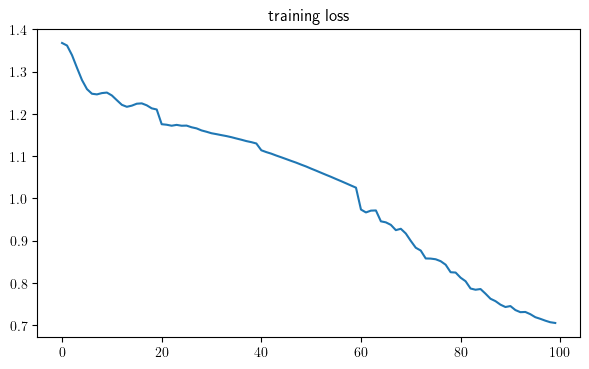

In [12]:
interval = 400
plt.figure(figsize=(7,4))
plt.plot(train_history)
plt.title("training loss")
# plt.xticks(range(1,num_training_epochs*epochs,interval), range(0,num_training_epochs,interval//epochs));

In [13]:
Q = csrl.q_learning(T=100,K=100000)
np.save(f'Q2_{p}', Q)

In [14]:
policy=np.argmax(Q,axis=4)
value=np.max(Q,axis=4)

In [15]:
rewards_mean = []
rewards_std = []
n_runs = 200

for i in T:
    episodes, rew = run_Q_test(csrl, policy, LTL_formula, predicates, T=i, start=(4,1), runs=n_runs, verbose=0)
    rewards_mean.append(100*np.mean(rew))
    rewards_std.append((rewards_mean[-1]-np.sqrt(n_runs*np.var(rew)), rewards_mean[-1]+np.sqrt(n_runs*np.var(rew))))
rewards_std = np.array(rewards_std)

Running 200 simulations with 10 time-steps...
Test finished with:
	success rate: 0 / 200 = 0.0


Text(0.5, 1.0, 'CSRL performance results on the nursery case, P=1')

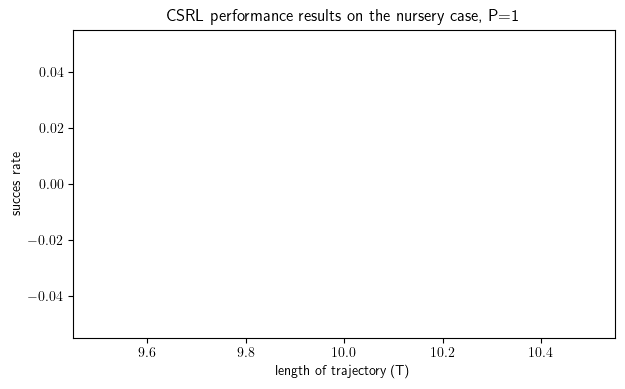

In [16]:
plt.figure(figsize=(7,4))
plt.fill_between(T, rewards_std[:,0], rewards_std[:,1], alpha=0.3, label="1 STD")

plt.plot(T, rewards_mean, label="CSRL")
plt.xlabel("length of trajectory (T)")
plt.ylabel("succes rate")
plt.title("CSRL performance results on the nursery case, P="+str(p))

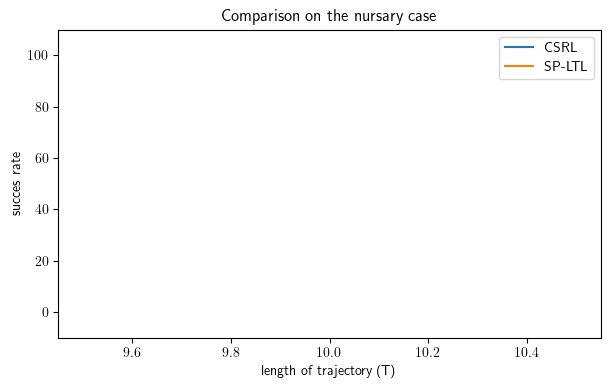

In [17]:
plt.figure(figsize=(7,4))

plt.fill_between(T, rewards_std[:,0], rewards_std[:,1], alpha=0.3)
plt.plot(T, rewards_mean, label="CSRL")
plt.xlabel("length of trajectory (T)")
plt.ylabel("succes rate")
plt.title("Comparison on the nursary case")
# plt.title("Comparison on the nursary case; deterministic")
plt.ylim(-10, 110)

plt.fill_between(T, succes_std[:,0], succes_std[:,1], alpha=0.3)
plt.plot(T, success_rates, label="RL-LTL")
plt.legend()
plt.savefig(f"res_400/C2_P{p}.pdf")